##Imports

In [ ]:
from skimage.data import brain
from skimage.transform import resize, rescale
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


##Load true image

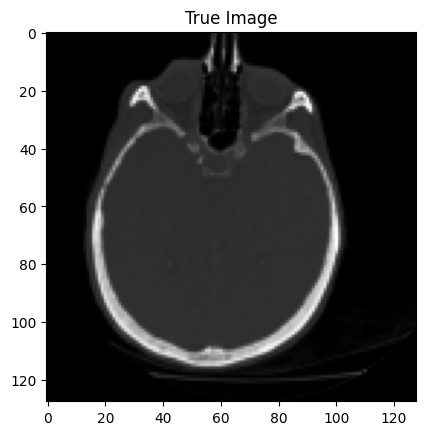

In [ ]:
plt.ion()
brainimage = brain()


# Dimensions of image
nxd = 128

true_object_np = resize(brainimage[9, 30: -1, : -30], (nxd, nxd), anti_aliasing=False)

plt.imshow(true_object_np, cmap='Greys_r')
plt.title('True Image')
plt.show()



##Define functions

In [ ]:
# Number of viewing angles in the sinogram
nphi = int(nxd * 1.42)

# Number of pixels in the radial dimension
nrd = int(nxd * 1.42)

# System matrix as a torch tensor
def make_torch_system_matrix(nxd, nrd, nphi):
    system_matrix = torch.zeros(nrd * nphi, nxd * nxd)  # Rows = num of sinogram bins, Cols = num of image pixels
    for xv in range(nxd):
        for yv in range(nxd):   #selext pixel with coordinates (xv, yv)
            for ph in range(nphi):  # For each angle, the pixel is projected
                yp = -(xv - (nxd * 0.5)) * np.sin(ph * np.pi / nphi) + (yv - (nxd * 0.5)) * np.cos(ph * np.pi / nphi)
                yp_bin = int(yp + nrd / 2.0)  #find where each pixel lands on the sinogram and build the system matrix
                system_matrix[yp_bin + ph * nrd, xv + yv * nxd] = 1.0
    return system_matrix

# Forward project the image using the system matrix
def fp_system_torch(image, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat, torch.reshape(image, (nxd * nxd, 1))), (nphi, nrd))

# Back project the sinogram to obtain an image
def bp_system_torch(sino, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat.T, torch.reshape(sino, (nrd * nphi, 1))), (nxd, nxd))

# Convert torch tensors to numpy arrays
def torch_to_np(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())

# Convert numpy arrays to torch tensors
def np_to_00torch(np_array):
    return torch.from_numpy(np_array).float().unsqueeze(0).unsqueeze(0)

#Create system matrix and true object sinogram as torch tensors

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Check if a GPU is available, otherwise use CPU
#print(device)

sys_mat = make_torch_system_matrix(nxd, nrd, nphi).to(device)  # System matrix for forward and back projection
true_object_torch = np_to_00torch(true_object_np).to(device)  # Convert the object into a torch tensor
true_sinogram_torch = fp_system_torch(true_object_torch, sys_mat, nxd, nrd, nphi)  # Forward project the torch tensor to obtain a true sinogram

##Define CNN architecture

In [ ]:

class CNN(nn.Module):
    def __init__(self, num_channels):
        super(CNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU(),
            nn.Conv2d(num_channels, 1, 3, padding=(1, 1), padding_mode='reflect'), nn.PReLU())

    def forward(self, x):
        x = torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))
        return x


##Class definition for DL FBP

In [ ]:
class FBP_CNN_Net(nn.Module):
    def __init__(self, cnn, sino_for_reconstruction):
        super(FBP_CNN_Net, self).__init__()#inherit attributes and methods from the base class, torch.nn
        self.sino_ones = torch.ones_like(sino_for_reconstruction)
        self.sens_image = bp_system_torch(self.sino_ones, sys_mat, nxd, nrd, nphi)
        self.cnn = cnn
        self.prelu = nn.PReLU()

    def forward(self, sino_for_reconstruction):
        filtered_sino = self.cnn(sino_for_reconstruction) #use the cnn to filter the sinogram
        recon = bp_system_torch(filtered_sino, sys_mat, nxd, nrd, nphi) / (self.sens_image + 1.0e-15) #division is similar to normalization of the image
        recon = self.prelu(recon)

        fig, axs = plt.subplots(2, 2, figsize=(12, 12))

        axs[0, 0].imshow(torch_to_np(filtered_sino), cmap='Greys_r')
        axs[0, 0].set_title('Filtered Sinogram')

        axs[0, 1].imshow(torch_to_np(recon), cmap='Greys_r')
        axs[0, 1].set_title('Reconstructed Image')

        fpsino = fp_system_torch(recon, sys_mat, nxd, nrd, nphi)

        axs[1, 0].imshow(torch_to_np(fpsino), cmap='Greys_r')
        axs[1, 0].set_title('Forward Projected Sinogram')

        axs[1, 1].imshow(torch_to_np(fpsino - sino_for_reconstruction), cmap='Greys_r')
        axs[1, 1].set_title('Difference')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.5)
        return recon, fpsino

#Training the CNN

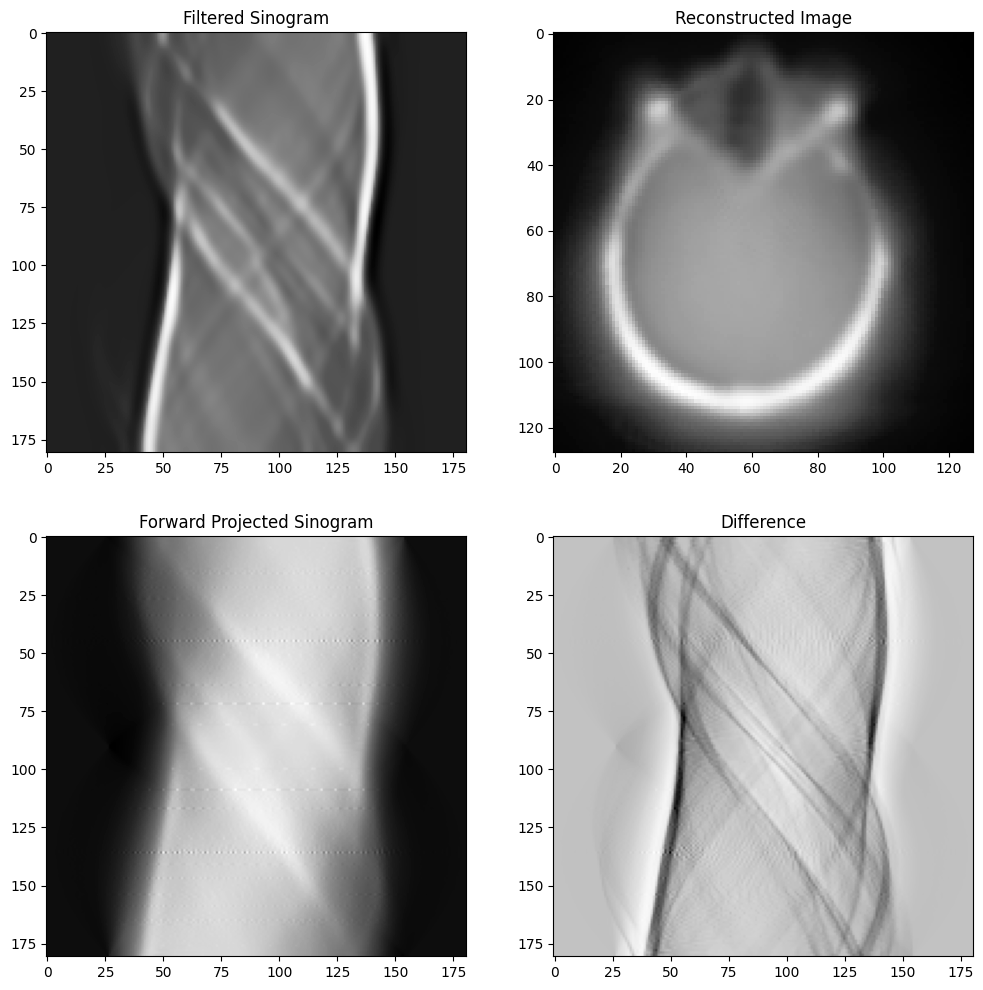

Epoch 2204 Training loss = 2.296980
Epoch 2204 Mean Absolute Error = 0.032821
Epoch 2204 SSIM = 0.405551
Epoch 2204 CC = 0.780825


In [ ]:
from skimage.metrics import structural_similarity as ssim

cnn = CNN(32).to(device)
#instantiate cnn with 32 channels

fbpnet = FBP_CNN_Net(cnn, true_sinogram_torch)

fbpnet.to(device)

loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(fbpnet.parameters(), lr=1e-5)

train_loss_mse = []
train_mae = []
train_ssim = []
train_CC = []

epochs = 5000

for epoch in range(epochs):
    fbp_recon, rec_fp = fbpnet(true_sinogram_torch)
    loss = loss_fun(rec_fp, torch.squeeze(true_sinogram_torch))
    train_loss_mse.append(loss.item())

    # Calculate Mean Absolute Error (MAE)
    mae_value = torch.mean(torch.abs(fbp_recon - true_object_torch))
    train_mae.append(mae_value.item())

    # Calculate SSIM between true image and reconstructed image
    fbp_recon_np = torch_to_np(fbp_recon)
    ssim_value = ssim(true_object_np, fbp_recon_np, data_range=fbp_recon_np.max() - fbp_recon_np.min())
    train_ssim.append(ssim_value)

    # Calculate Correlation Coefficient (CC)
    cc_value = np.corrcoef(true_object_np.ravel(), fbp_recon_np.ravel())[0, 1]
    train_CC.append(cc_value)


    loss.backward()  # Compute gradient with respect to loss using backpropagation
    optimizer.step()  # Update the weights based on computed gradients
    optimizer.zero_grad()  # Reset the gradients to zero for the next iteration
    print('Epoch %d Training loss = %f' % (epoch, train_loss_mse[-1]))
    print('Epoch %d Mean Absolute Error = %f' % (epoch, train_mae[-1]))
    print('Epoch %d SSIM = %f' % (epoch, train_ssim[-1]))
    print('Epoch %d CC = %f' % (epoch, train_CC[-1]))


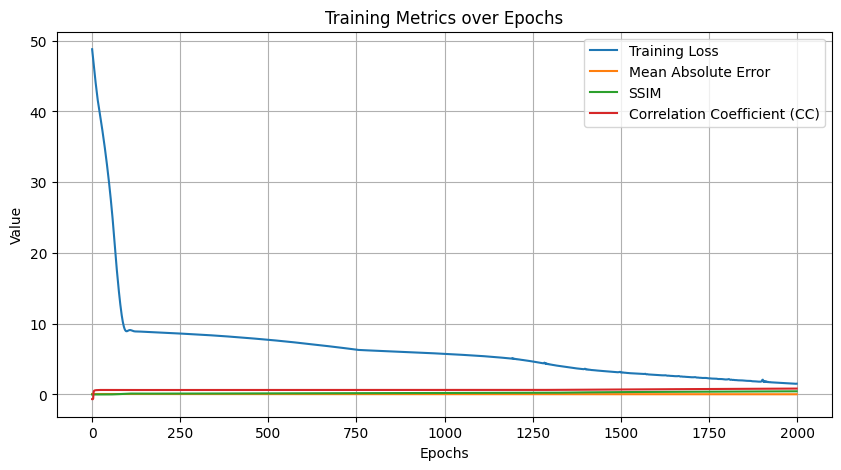

In [ ]:
# Plotting the training metrics
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(train_loss_mse, label='Training Loss', marker = '')

# Plot Mean Absolute Error
plt.plot(train_mae, label='Mean Absolute Error', marker = '')

# Plot SSIM
plt.plot(train_ssim, label='SSIM', marker = '')

# Plot CC
plt.plot(train_CC, label='Correlation Coefficient (CC)', marker = '')


plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import csv

# Define file name
file_name = "training_metrics.csv"

# Write the values to the CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Training Loss (MSE)", "Mean Absolute Error", "SSIM", "Correlation Coefficient (CC)"])
    for epoch, loss, mae, ssim, cc, convergence in zip(range(1, epochs+1), train_loss_mse, train_mae, train_ssim, train_CC):
        writer.writerow([epoch, loss, mae, ssim, cc])

print("Values saved to", file_name)
